In [1]:
import arviz as az
import pymc as pm
# import arviz.labels as azl

import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pickle
import matplotlib as mpl
import warnings
import numpy as np
warnings.simplefilter(action='ignore', category=FutureWarning)

## Reestimate model because of pickle problems

In [2]:
def gamma(alpha, beta):
    def g(x):
        return pm.Gamma(x, alpha=alpha, beta=beta)
    return g

def hcauchy(beta):
    def g(x):
        return pm.HalfCauchy(x, beta=beta)
    return g


def fit_gp(y, X, l_prior, eta_prior, sigma_prior, kernel_type='M52', bayes_kws=dict(draws=1000, tune=1000, chains=2, cores=1), prop_Xu=None):
    """
    function to return a pymc3 model
    y : dependent variable
    X : independent variables
    prop_Xu : number of inducing varibles to use. If None, use full marginal likelihood. If not none, use FTIC. 
    bayes_kw : kws for pm.sample
    X, y are dataframes. We'll use the column names. 
    """
    kernel_type = kernel_type.lower()
    with pm.Model() as model:
        # Covert arrays
        X_a = X.values
        y_a = y.values.flatten()
        X_cols = list(X.columns)

        
        # Kernels
        # 3 way interaction
        eta = eta_prior('eta')
        cov = eta**2
        for i in range(X_a.shape[1]):
            var_lab = 'l_'+X_cols[i]
            if kernel_type=='rbf':
                cov = cov*pm.gp.cov.ExpQuad(X_a.shape[1], ls=l_prior(var_lab), active_dims=[i])
            if kernel_type=='exponential':
                cov = cov*pm.gp.cov.Exponential(X_a.shape[1], ls=l_prior(var_lab), active_dims=[i])
            if kernel_type=='m52':
                cov = cov*pm.gp.cov.Matern52(X_a.shape[1], ls=l_prior(var_lab), active_dims=[i])
            if kernel_type=='m32':
                cov = cov*pm.gp.cov.Matern32(X_a.shape[1], ls=l_prior(var_lab), active_dims=[i])

        # Covariance model
        cov_tot = cov 
        
        # Noise model
        sigma_n =sigma_prior('sigma_n')

        # Model
        if not (prop_Xu is None):
            # Inducing variables
            num_Xu = int(X_a.shape[0]*prop_Xu)
            Xu = pm.gp.util.kmeans_inducing_points(num_Xu, X_a)
            gp = pm.gp.MarginalSparse(cov_func=cov_tot, approx="FITC")
            y_ = gp.marginal_likelihood('y_', X=X_a, y=y_a, Xu=Xu, noise=sigma_n)
        else:
            gp = pm.gp.Marginal(cov_func=cov_tot)
            y_ = gp.marginal_likelihood('y_', X=X_a, y=y_a, noise=sigma_n)
            
        
        if not (bayes_kws is None):
            trace = pm.sample(**bayes_kws)
            result = trace
        else:
            mp = pm.find_MAP()
            result = mp
    
    return gp, result, model

In [3]:
root_path = '1fme/sensitivity'
experiments = [['dihedrals', None, 'exponential'], ['distances', 'linear', 'exponential'], ['distances', 'logistic', 'exponential']]
models = []
for feat, trans, kernel in experiments:

    results_path = Path(root_path).joinpath(f"{feat}_{trans}_{kernel}_mml.pkl")

    results = pickle.load(results_path.open('rb'))
    data_s = results['data']
    y, X = data_s.iloc[:, [0]], data_s.iloc[:, 1:]
    bayes_kws = dict(draws=2000, tune=1000, chains=4, cores=4, target_accept=0.90)
    
    # Fit model
    l_prior = gamma(2, 0.5)
    eta_prior = hcauchy(2)
    sigma_prior = hcauchy(2)
    gp, trace, model = fit_gp(y=y, X=X,  # Data
                                    l_prior=l_prior, eta_prior=eta_prior, sigma_prior=sigma_prior,  # Priors
                                    kernel_type=kernel,  # Kernel
                                    prop_Xu=None,  # proportion of data points which are inducing variables.
                                    bayes_kws=bayes_kws)  #
    models.append((gp, trace, model))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eta, l_dim, l_lag, l_states, sigma_n]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 102 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eta, l_scheme[T.closest-heavy], l_dim, l_lag, l_states, sigma_n]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 95 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eta, l_scheme[T.closest-heavy], l_dim, l_lag, l_states, l_steep, l_cent, sigma_n]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 361 seconds.


In [4]:
from copy import deepcopy


var_name_map_1={"l_states": r"Num. states", 
            "l_dim": r"Num. dims", 
            "l_lag": r"$\tau_{tICA}$"}

var_name_map_2 = deepcopy(var_name_map_1)
var_name_map_2.update({"l_cent": r"Centre", 
             "l_steep": r"Steepness"})


maps = [var_name_map_1, var_name_map_1, var_name_map_2]
             

In [5]:
traces = [deepcopy(x[1]) for x in models]
traces   = [x.rename_vars(maps[i]) for i, x in enumerate(traces)]

Relevance

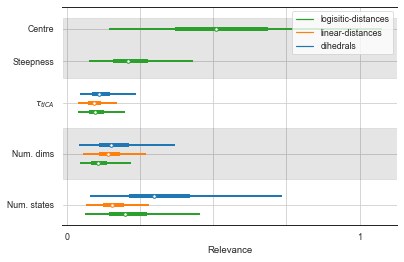

In [8]:
def R(x): 
    return 1/x
    
with sns.plotting_context('paper'):
    sns.set_style('white')
    
    fig, ax = plt.subplots(1)
    
    ax.set_xlabel("Relevance")
    
    pm.plot_forest(traces, 
                   model_names=['dihedrals','linear-distances', 'logisitic-distances'], 
                   combined=True, 
                   linewidth=2, 
                   var_names=[ r"Centre", r"Steepness", r"$\tau_{tICA}$", r"Num. dims", r"Num. states"], 
                   transform=R, 
                   ax=ax, 
                   hdi_prob=0.95, legend=True)
    
    ax.set_title('')
    # ax.set_xlim(-0.1, 2)
    ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
    ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.25))
    
    ax.grid(which='both')
    plt.savefig(Path(root_path).joinpath('relevance_forestplot.pdf'), bbox_inches='tight')
    


Accuracy plot

In [9]:
predictions = []

for _, trace, model in [models[-1]]:
    thin_trace = trace.posterior.sel(draw=slice(0, None, 1))
    with model:
        pred_samples = pm.sample_posterior_predictive(thin_trace)
    y_obs = pred_samples.observed_data.y_
    y_pred_samples = np.array(pred_samples.posterior_predictive.y_)
    y_pred = np.mean(y_pred_samples, axis=(0, 1))
    y_lb = np.quantile(y_pred_samples, q=0.025, axis=(0, 1))
    y_ub = np.quantile(y_pred_samples, q=0.975, axis=(0, 1))
    predictions.append((y_obs, y_pred, y_lb, y_ub))
    

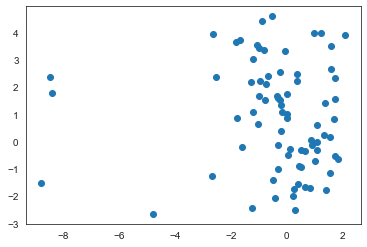

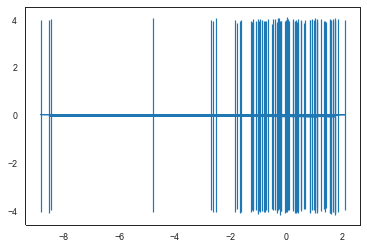

In [10]:
with sns.plotting_context('paper'): 
    fig, ax = plt.subplots(1)
    for pred in predictions: 
        ax.errorbar(pred[0], pred[1], yerr=(pred[1]-pred[2], pred[3]-pred[1]))
    # plt.ylim(0, 1)
    # plt.xlim(0, 1)

In [23]:
??az.plot_lm

Signature:
az.plot_lm(
    y,
    idata=None,
    x=None,
    y_model=None,
    y_hat=None,
    num_samples=50,
    kind_pp='samples',
    kind_model='lines',
    xjitter=False,
    plot_dim=None,
    backend=None,
    y_kwargs=None,
    y_hat_plot_kwargs=None,
    y_hat_fill_kwargs=None,
    y_model_plot_kwargs=None,
    y_model_fill_kwargs=None,
    y_model_mean_kwargs=None,
    backend_kwargs=None,
    show=None,
    figsize=None,
    textsize=None,
    axes=None,
    legend=True,
    grid=True,
)
Source:   
def plot_lm(
    y,
    idata=None,
    x=None,
    y_model=None,
    y_hat=None,
    num_samples=50,
    kind_pp="samples",
    kind_model="lines",
    xjitter=False,
    plot_dim=None,
    backend=None,
    y_kwargs=None,
    y_hat_plot_kwargs=None,
    y_hat_fill_kwargs=None,
    y_model_plot_kwargs=None,
    y_model_fill_kwargs=None,
    y_model_mean_kwargs=None,
    backend_kwargs=None,
    show=None,
    figsize=None,
    textsize=None,
    axes=None,
    legend=True,
    

In [20]:
??az.plot_ppc

Signature:
az.plot_ppc(
    data,
    kind='kde',
    alpha=None,
    mean=True,
    observed=True,
    color=None,
    colors=None,
    grid=None,
    figsize=None,
    textsize=None,
    data_pairs=None,
    var_names=None,
    filter_vars=None,
    coords=None,
    flatten=None,
    flatten_pp=None,
    num_pp_samples=None,
    random_seed=None,
    jitter=None,
    animated=False,
    animation_kwargs=None,
    legend=True,
    labeller=None,
    ax=None,
    backend=None,
    backend_kwargs=None,
    group='posterior',
    show=None,
)
Source:   
def plot_ppc(
    data,
    kind="kde",
    alpha=None,
    mean=True,
    observed=True,
    color=None,
    colors=None,
    grid=None,
    figsize=None,
    textsize=None,
    data_pairs=None,
    var_names=None,
    filter_vars=None,
    coords=None,
    flatten=None,
    flatten_pp=None,
    num_pp_samples=None,
    random_seed=None,
    jitter=None,
    animated=False,
    animation_kwargs=None,
    legend=True,
    labeller=None,
 